In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.datasets import make_classification, load_iris
from sklearn.neighbors import NearestNeighbors

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

In [2]:
def swiss_roll(n): #from lab 1 +  labels added
    """
    Parameters:
    n: int
        Number of points to generate"""
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate

    color = data[:,0]**2 + data[:,1]**2

    return data, color

In [3]:
X, y = swiss_roll(1000)

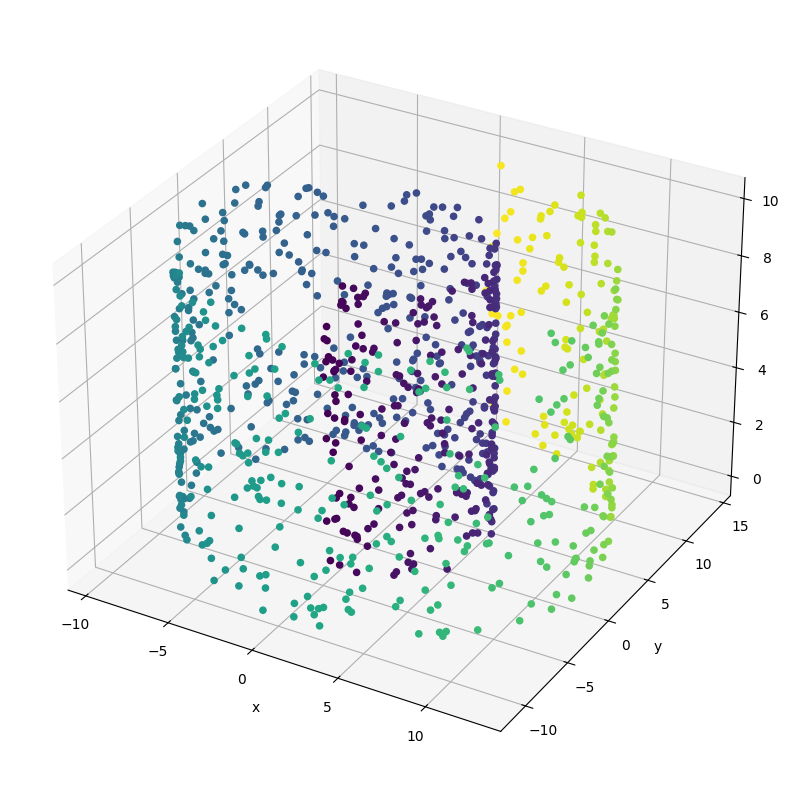

In [4]:
plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
axes.scatter3D(X[:,0], X[:,1], X[:,2],c=y, alpha = 1)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(90,0) #(elevation, azimuth angle)

plt.show()

# Raw isomap implementation

Steps for isomap:
1. Construct weighted graph
2. Obtain distance matrix
3. Perform MDS

Steps for MDS:
1. Get the distance matrix
2. Calculate the Gram matrix
3. Eigendecomposition

Resources:
- https://nbviewer.org/github/drewwilimitis/Manifold-Learning/blob/master/Isomap.ipynb
- https://stackoverflow.com/questions/61417929/coding-isomap-mds-function-using-only-numpy-and-scipy-in-python
- https://github.com/lwileczek/isomap/blob/master/isomap.py

In [ ]:
def mds(delta, N, d):
    # delta: distance matrix; N: size of the input

    #gram matrix construction
    G=np.zeros((N,N))
    square_delta=np.square(delta)
    #print("square delta\n",square_delta)
    const=(1/(N*N))*np.sum(square_delta)
    #print("const\n",const)
    for i in range(N):
        for j in range(N):
            G[i,j]=-0.5*(square_delta[i,j])+0.5*((1/N)*(np.sum(square_delta[:,j])+np.sum(square_delta[i,:]))-const)

    #print("G\n",G)
    #computing the eigenvectors and eigenvalues of the G matrix
    eigen_values, eigen_vectors = np.linalg.eig(G)
    #print("eig val\n",eigen_values)
    #print("eig vec\n",eigen_vectors)
    #sorting eigenvalues from higher to lower
    sorted_index=np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    #print("sorted eig val\n",sorted_eigenvalue)
    #print("sorted eig vec\n",sorted_eigenvectors)

    #d choosen eigenvalues and corresponding eigvectors
    choosen_eigenvalue = sorted_eigenvalue[0:d]
    choosen_eigenvectors = sorted_eigenvectors[:,0:d]
    lambda_matrix = np.diag(choosen_eigenvalue)
    lambda_matrix_sqrt=np.sqrt(lambda_matrix)

    #projection Y=V*lambdasqrt
    #print("choosen eigval\n",choosen_eigenvalue)
    #print("chooesen eigvect\n",choosen_eigenvectors)
    #print("lambda mat sqrt\n",lambda_matrix_sqrt)
    projections = np.matmul(choosen_eigenvectors, lambda_matrix_sqrt).real

    return projections, choosen_eigenvalue



In [ ]:
def isomap(X, k, d):
    # X:data; k: nearest neighbors number, d: number of eigenvalues to keep
    N=len(X)
    nbrs=NearestNeighbors(n_neighbors=k,algorithm='auto').fit(X)
    dist_matrix=np.matrix(np.zeros((N,N)))
    dist, index=nbrs.kneighbors()
    for i in range(len(index)):
        for j in range(len(index[i])):
            dist_matrix[i,index[i,j]]=dist[i,j]
            dist_matrix[index[i,j],i]=dist[i,j]

    #print("dist matrix\n",dist_matrix)

    #floy-warshall algorithm for shortest path matrix
    #delta=myFWalg(N,dist_matrix)
    #print("delta\n",delta)
    delta=np.matrix((np.ones((N,N))) * np.inf)
    #diagonal elements set to zero
    np.fill_diagonal(delta,0)
    #distances between points
    #metto elementi di dist diversi da zero in delta
    for i in range(N):
        for j in range(N):
            if dist_matrix[i,j]!=0:
                delta[i,j]=dist_matrix[i,j]

    for k in range(N):
        for i in range(N):
            for j in range(N):
                if delta[i,j]>delta[i,k]+delta[k,j]:
                    delta[i,j]=delta[i,k]+delta[k,j]
    
    return mds(delta, N, d)